In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import numpy.random as r

# Her i starten indlæses bare data og korrigeres for k_acc, som vi har gjort tidligere. Led efter næste markdown, hvor der står, at der er ændringer

Text(0.5, 1.0, 'Gennemsnitlig temperaturafvigelse gennem den Holocæne periode')

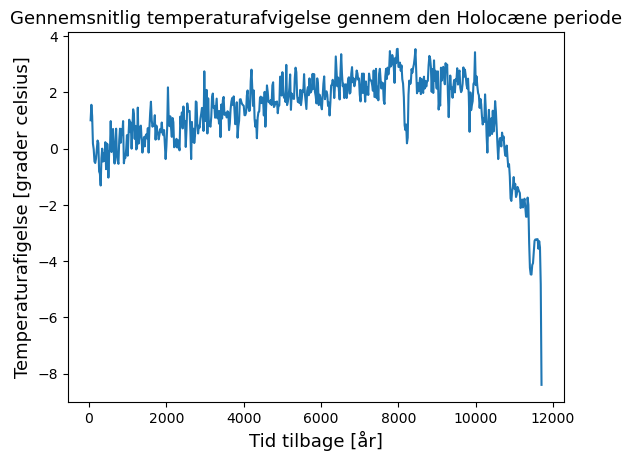

In [89]:
rådata_holocæn = pd.read_excel('Temperaturdata_alene.xlsx', header = 29)
rådata_holocæn = rådata_holocæn.to_numpy()
år20_rå = rådata_holocæn[:,0]
temp20_rå = rådata_holocæn[:,1]

plt.plot(år20_rå,temp20_rå)

plt.xlabel('Tid tilbage [år]', fontsize = 13)
plt.ylabel('Temperaturafigelse [grader celsius]', fontsize = 13)
plt.title("Gennemsnitlig temperaturafvigelse gennem den Holocæne periode", fontsize = 13)

In [6]:
rådata = pd.read_excel('Ægte_DailyMinMax_Ilullisat_Cor-2.xlsx')
print(rådata)
data = rådata.to_numpy()
år_rå, temp_rå = data[:,0], data[:,1]

               Yr       Temp  Completeness
0       1873.0000 -20.131622             2
1       1873.0014 -12.826645             2
2       1873.0027 -20.587018             2
3       1873.0041 -12.755726             2
4       1873.0055 -21.348169             2
...           ...        ...           ...
108109  2020.9932  -3.317742             0
108110  2020.9945  -4.417742             0
108111  2020.9959   1.182258             0
108112  2020.9973   0.000000             0
108113  2020.9986   0.000000             0

[108114 rows x 3 columns]


Interpolering af DMI-data

In [87]:
def interpolation_år():
    interpol_år = []
    år = []
    temp = []
    for i in range(1, len(år_rå)):      # Finder mellempunkter for årsarrayet
        punkt = (år_rå[i] + år_rå[i-1])/2
        interpol_år.append(punkt)

    for i in range(len(interpol_år)):   # Laver liste med både DMI-årstal og mellempunkter
        år.append(år_rå[i])
        år.append(interpol_år[i])
    år.append(år_rå[-1])   # Tilføjer det sidste rå datapunkt manuelt, da der et ét råt datapunkt mere end mellempunkterne.
    return np.array([år])
    
år = interpolation_år()      # Interpolerer temperaturdataen
år = år[0]

temp = np.interp(år, år_rå, temp_rå)


In [8]:
råsatellit = pd.read_csv('greenland_mass_200204_202311.txt', delimiter = '\s+', header = None, skiprows = lambda x: x < 31)
satellit = råsatellit.to_numpy()
år_sat, dmasse_sat = satellit[:, 0], satellit[:, 1]
densitet_is = 917
dvol_sat = 10**12 * dmasse_sat/densitet_is   # Vi omregner massetilvækst til volumentilvækst
V_sat_err = 10**12 * abs(1/densitet_is * satellit[:,2])

In [9]:
# Slicing af DMI-data
top = max(år_sat)   
bund = min(år_sat)
temp = temp[(år <= top) & (år >= bund)] # Nyt temperatur-array, som kun indeholder temperaturer for samme årrække som satellitdata
år = år[(år <= top) & (år >= bund)] # Sørger for, at vi også har et årstals-array med de tilsvarende indgange (samme maske)

# Slicing af GRACE-data
topDMI = max(år)
dmasse_sat = dmasse_sat[år_sat <= topDMI]
dvol_sat = dvol_sat[år_sat <= topDMI]
V_sat_err = V_sat_err[år_sat <= topDMI]
år_sat = år_sat[år_sat <= topDMI]

In [10]:
råNGRIP = pd.read_excel('rådata NGRIP_acc_Vinther_etal_2009_GICC05_16Sep2010.xlsx', header = 58, usecols = [0,1,2,3,4,5,6,7,8])
råGRIP = pd.read_excel('GRIP_acc_Vinther_etal_2009_GICC05_16Sep2010.xlsx', header = 54, usecols = [0,1,2,3,4,5,6,7])

NGRIP, GRIP = råNGRIP.to_numpy(), råGRIP.to_numpy()
NGRIPakk0, GRIPakk0 = NGRIP[:, 6], GRIP[:, 5]
NGRIPår0, GRIPår0 = NGRIP[:, 1], GRIP[:, 1]

In [11]:
akk_list = (NGRIPakk0[1:21] + GRIPakk0[1:21])/2   # Tager ikke første punkt med grunden manglende nedbørsdata
akk_gns = np.mean(akk_list)
print('gns akkumulation = ', akk_gns)

gns akkumulation =  0.2034321448890318


In [18]:
def optimering_akk(M_akk_tabel):

    dvol_sat_korr = dvol_sat - np.mean(dvol_sat) # volumenændringer for GRACE korrigeres, så det har nulpunkt i sit gennemsnit


    V_start = 2.99 * 10**15   # startvolumen af iskappe
    H = 3 * 10**3       # Starthøjde af iskappe
    V = V_start  # startvolumen af iskappe
    V_0 = V_start 
    V_sat = dvol_sat + V_0 - dvol_sat[0]
    
    R = (3/16*V/H)**(1/2)    # Startradius af iskappe
    T_f = 0        
    alfa = - 9.8 * 10**(-3)  # konstant hvormed temperatur stiger per meter
    k = H/np.sqrt(R)   # formfaktor for iskappe. Antages global konstant
    dt = 1/(365.25 * 4)  # Tidsskridt (her 1/4 døgn) - omregnet til år

    acc = akk_gns   # Nedbør pr år [m/år]. Antages konstant i perioden
    k_acc_test = 1   # Denne tuningskonstant kommer fra vores undervurdering af nedbøren. Den kan vi også tune på, hvis nødvendigt. 
    k_melt = 1

    #Der oprettes tomme lister til resultatet af simuleringen
    V_list = []
    V_melt_list = []
    V_acc_list = []


    for i in range(len(år)):
        R = (3/16 * V/k)**(2/5)     # Ny radius af iskappe
       
        V_acc = k_acc_test * (acc * 8 * R**2) * dt  # Nedbøret dette tidsskridt
       
        if temp[i] - T_f <= 0:
            V_melt = 0
        elif temp[i] - T_f > 0:
            V_melt = k_melt * 8/3 * R * (temp[i] - T_f) * ((T_f - temp[i])/(alfa * k))**2 * dt  # ganger tidsskridt og M på
        V += V_acc - V_melt

        V_list.append(V)
        V_melt_list.append(V_melt)
        V_acc_list.append(V_acc)

   
    V_sum = np.sum(V_acc_list)/(år[-1] - år[0])
    V_akk_tabel = (M_akk_tabel)/(densitet_is) #m^3

    k_acc = V_akk_tabel/V_sum
    
    return k_acc

In [19]:
M_akk_mean = 642 * 10**12

optimering_akk(M_akk_mean)

2.30089779452381

In [66]:
M_akk_mean = 642 * 10**12    #kg
M_akk_std = 59 * 10**12    #kg

M_akk_list = r.normal(M_akk_mean, M_akk_std, 10)

k_acc_værdier = []

for x in M_akk_list:
    k_acc = optimering_akk(x)

    k_acc_værdier.append(k_acc)

print(k_acc_værdier)

tester = [M_akk_mean - M_akk_std, M_akk_mean, M_akk_std + M_akk_mean]
print(tester)

[2.1609208963963353, 2.1551366568200128, 2.3113111973642853, 2.3907284622074227, 2.7051778531212807, 1.7686770829706424, 2.4891241092836216, 2.0229331490000986, 2.483473571865444, 2.5266390308184756]
[583000000000000, 642000000000000, 701000000000000]


# __HERFRA NYT__

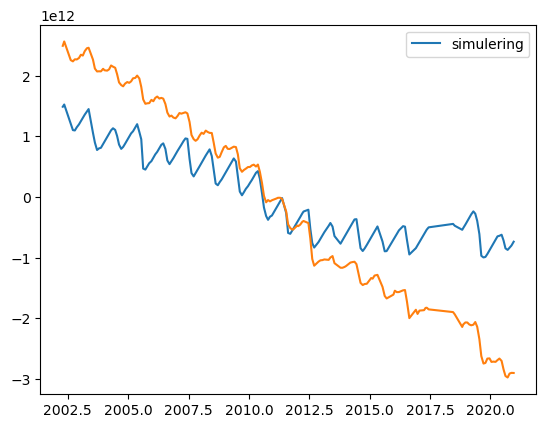

In [86]:
V_start = 2.99 * 10**15   # startvolumen af iskappe
dvol_sat_korr = dvol_sat - np.mean(dvol_sat) # volumenændringer for GRACE korrigeres, så det har nulpunkt i sit gennemsnit
dvol_sat_err_korr = np.sqrt(V_sat_err**2 + (np.std(dvol_sat)/np.sqrt(len(dvol_sat)))**2)


def simulering(år_sat, k_melt):
    
    # De globale konstanter defineres
    V = V_start  # startvolumen af iskappe
    V_0 = V_start 
    H = 3 * 10**3       # Starthøjde af iskappe
    R = (3/16*V/H)**(1/2)     # Startradius af iskappe
    T_f = 0        
    alfa = - 9.8 * 10**(-3)  # konstant hvormed temperatur stiger per meter
    k = H/np.sqrt(R)   # formfaktor for iskappe. Antages global konstant
    dt = 1/(365.25 * 4)  # Tidsskridt (her 1/4 døgn) - omregnet til år
    
    acc = akk_gns   # Nedbør pr år [m/år]. Antages konstant i perioden

    
    # Der oprettes tomme lister til resultatet af simuleringen
    V_list = []
    V_melt_list = []
    V_acc_list = []
    
    
    for i in range(1, len(år) + 1):
        R = (3/16 * V/k)**(2/5)     # Ny radius af iskappe
        
        V_acc = k_acc * (acc * 8 * R**2) * dt  # Nedbøret dette tidsskridt
        
        if temp[-i] - T_f <= 0:
            V_melt = 0
        elif temp[-i] - T_f > 0:
            V_melt = k_melt * 8/3 * R * (temp[-i] - T_f) * ((T_f - temp[-i])/(alfa * k))**2 * dt  # ganger tidsskridt og M på
        V +=  - V_acc + V_melt
        
        V_list.append(V)
        V_melt_list.append(V_melt)
        V_acc_list.append(V_acc)
    
    V_list.reverse()

    dvol_sim = V_list - np.mean(V_list)

    dvol_sim_fit = np.interp(år_sat, år, dvol_sim)

    return dvol_sim_fit 


# Nedenstående er bare et tjek af den nye funktion, som er lidt anderledes end de gamle
test = simulering(år_sat, 6.7)

#plt.plot(år, V_list)
plt.plot(år_sat, test, label = 'simulering')
plt.plot(år_sat, dvol_sat_korr)
plt.legend()


## Curve_fit

In [75]:
k_melt_list = []
k_melt_err_list = []

for x in k_acc_værdier:
    k_acc = x
    par, cov = curve_fit(simulering, år_sat, dvol_sat_korr, p0 = 1, sigma = dvol_sat_err_korr, absolute_sigma= True)
    k_melt_list.append(par[0])
    k_melt_err_list.append(np.sqrt(cov[0,0]))

In [76]:
print(k_melt_list)
print(k_melt_err_list)

[6.77480842342003, 6.762312410519031, 7.099466190672611, 7.270891824074023, 7.949708912236804, 5.928024186809553, 7.483306786485404, 6.476922416697892, 7.47110285235064, 7.5642889370817565]
[0.011388509193283896, 0.011389593961624141, 0.011388181401019964, 0.011389115125444178, 0.01139155159307188, 0.011387659699327224, 0.011392316174654641, 0.011387282024480859, 0.0113918449438338, 0.011390503399538331]


# __Lange kørsler__

Forskellen er 5.5608806093626635


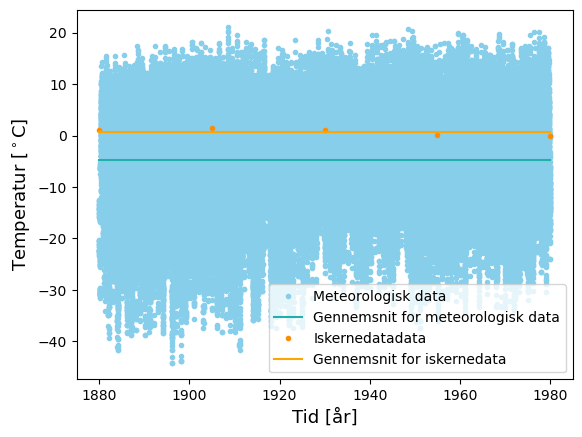

In [90]:
gns1 = np.average(temp20_rå[0:5])

top = 1980
bund = 1880
temp_X = temp_rå[(år_rå >= bund)&(år_rå < top)]

gns2 = np.average(temp_X)

forskel = np.absolute(gns1 - gns2)

plt.plot(np.linspace(1880,1980,len(temp_X)),temp_X, '.', c = 'skyblue', label = 'Meteorologisk data')
plt.plot(np.linspace(1880,1980,100), np.linspace(gns2,gns2,100), c = 'lightseagreen', label = 'Gennemsnit for meteorologisk data')

plt.plot(np.linspace(1880,1980,5),temp20_rå[0:5], '.', c = 'darkorange', label = 'Iskernedatadata')
plt.plot(np.linspace(1880,1980,100), np.linspace(gns1,gns1,100), c = 'orange', label = 'Gennemsnit for iskernedata')

plt.legend()
plt.xlabel('Tid [år]', fontsize = 13)
plt.ylabel(r'Temperatur [$^\circ$C]', fontsize = 13)

print("Forskellen er", forskel)

## Simulering af iskappevolumensudvikling gennem den sidste varmeperiode

### Udvælger 20 år (år 1955-1975) og bruger deres årstidscyklus på iskernedata

[0.000000e+00 7.000000e-04 1.400000e-03 ... 1.999795e+01 1.999860e+01
 1.999930e+01]


Text(0, 0.5, 'Temperaturafvigelse [$^\\circ$C]')

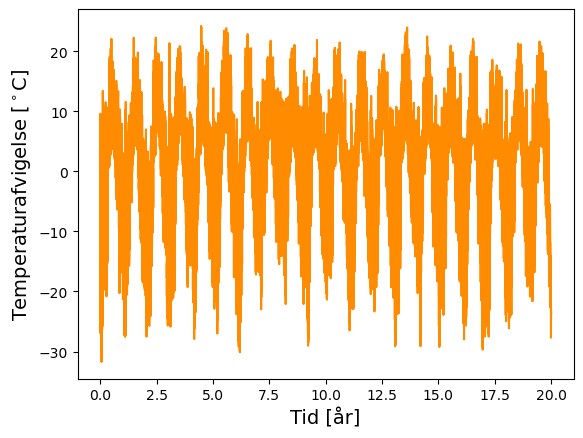

In [96]:
top = 1975
bund = 1955
maske = (år >= bund) & (år < top)

år_X = år[maske]
år_X = år_X - min(år_X)
temp_X = temp[maske]
temp_X_afv = temp_X-np.average(temp_X)

print(år_X)
plt.plot(år_X,temp_X_afv, c = 'darkorange')
plt.xlabel('Tid [år]', fontsize = 14)
plt.ylabel(r'Temperaturafvigelse [$^\circ$C]', fontsize = 14)

In [93]:
print(år20_rå)

[   40.    60.    80.   100.   120.   140.   160.   180.   200.   220.
   240.   260.   280.   300.   320.   340.   360.   380.   400.   420.
   440.   460.   480.   500.   520.   540.   560.   580.   600.   620.
   640.   660.   680.   700.   720.   740.   760.   780.   800.   820.
   840.   860.   880.   900.   920.   940.   960.   980.  1000.  1020.
  1040.  1060.  1080.  1100.  1120.  1140.  1160.  1180.  1200.  1220.
  1240.  1260.  1280.  1300.  1320.  1340.  1360.  1380.  1400.  1420.
  1440.  1460.  1480.  1500.  1520.  1540.  1560.  1580.  1600.  1620.
  1640.  1660.  1680.  1700.  1720.  1740.  1760.  1780.  1800.  1820.
  1840.  1860.  1880.  1900.  1920.  1940.  1960.  1980.  2000.  2020.
  2040.  2060.  2080.  2100.  2120.  2140.  2160.  2180.  2200.  2220.
  2240.  2260.  2280.  2300.  2320.  2340.  2360.  2380.  2400.  2420.
  2440.  2460.  2480.  2500.  2520.  2540.  2560.  2580.  2600.  2620.
  2640.  2660.  2680.  2700.  2720.  2740.  2760.  2780.  2800.  2820.
  2840

## Lægger årstidscyklus ind over iskernedata

In [98]:
temp_array = np.array([])
år_array = np.array([])

for i, j in np.nditer([temp20_rå, år20_rå]):
    temp_c = i + temp_X - forskel #kysttemperatur
    år_c = 2000 - j + 20 + år_X

    temp_array = np.append(temp_array, temp_c)
    år_array = np.append(år_array, år_c)

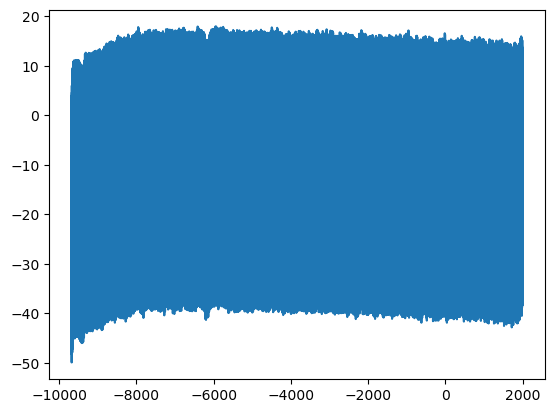

In [99]:
plt.plot(år_array, temp_array)

(0.0, 25.0)

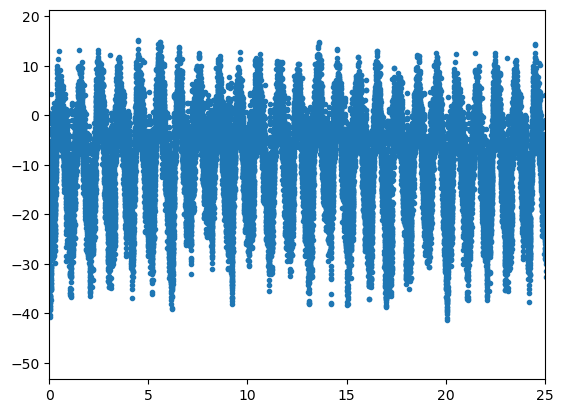

In [103]:
plt.plot(år_array, temp_array, '.')
plt.xlim(0,25)

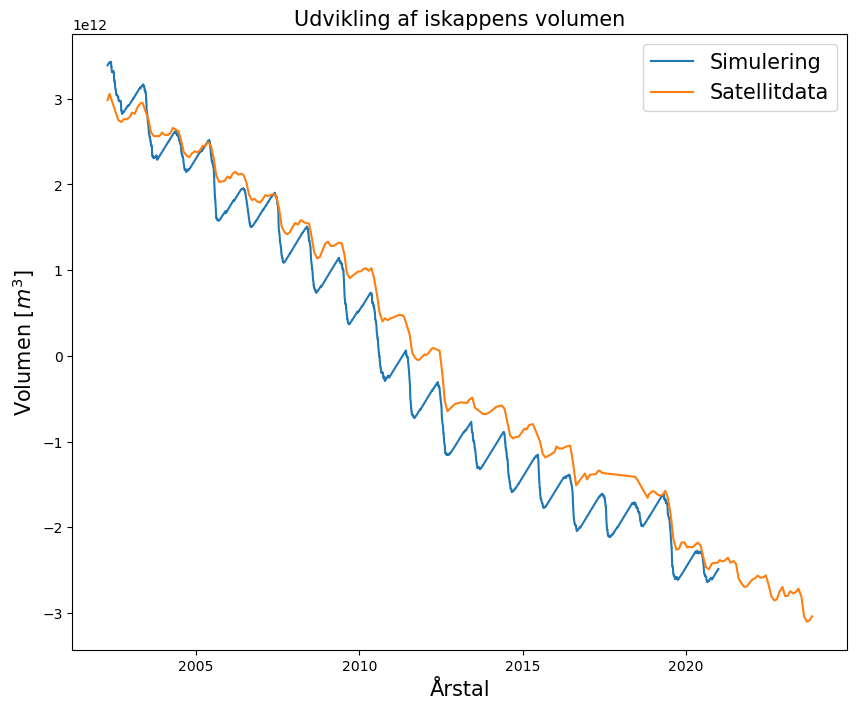

In [63]:
# De globale konstanter defineres
V_0 = 2.85 * 10**15
V = 2.85 * 10**15   # startvolumen af iskappe
h = 3 * 10**3       # Starthøjde af iskappe
R = 500 * 10**3     # Startradius af iskappe
T_f = 0        
alfa = - 9.8 * 10**(-3)  # konstant hvormed temperatur stiger per meter
k = h/np.sqrt(R)   # formfaktor for iskappe. Antages global konstant
dt = 1/(365.25 * 4)  # Tidsskridt (her 1/2 døgn) - omregnet til år

# Tuningskonstanter
k_melt = par[0]
acc = akk_gns   # Nedbør pr år [m/år]. Antages konstant i perioden


# Der oprettes tomme lister til resultatet af simuleringen
V_list = []
V_melt_list = []
V_acc_list = []


for i in range(1, len(år) + 1):
    R = (3/16 * V/k)**(2/5)     # Ny radius af iskappe
    
    V_acc = k_acc * (acc * 8 * R**2) * dt  # Nedbøret dette tidsskridt
    
    if temp[-i] - T_f <= 0:
        V_melt = 0 
    elif temp[-i] - T_f > 0:
        V_melt = k_melt * 8/3 * R * (temp[-i] - T_f) * ((T_f - temp[-i])/(alfa * k))**2 * dt # ganger tidsskridt og M på
    V +=  - V_acc + V_melt
    
    V_list.append(V)
    V_melt_list.append(V_melt)
    V_acc_list.append(V_acc)

V_list.reverse()
dvol_sim = V_list - np.mean(V_list)
    
# Plot
    
plt.figure(figsize = (10,8))
plt.plot(år , dvol_sim, label = 'Simulering')
plt.xlabel('Årstal', fontsize = 15)
plt.ylabel(r'Volumen $[m^3]$', fontsize = 15)
plt.title('Udvikling af iskappens volumen', fontsize = 15)

plt.plot(år_sat, dvol_sat_korr, label = 'Satellitdata')
plt.legend(fontsize = 15)
plt.savefig('Tuning af smeltekonstant.png')
